# Hemoglobin
A primary function of the red blood cell (RBC) is to carry oxygen bound to hemoglobin through circulation. Hemoglobin can bind to a number of small molecule ligands that affect its oxygen carrying function. The binding of small molecule ligands to a protein like hemoglobin can be described by elementary chemical equations. As we discussed in in Chapter 5, all such chemical equations can be assembled into a stoichiometric matrix that describes all the bound states of the protein. Such a stoichiometric matrix describes the functions of a module, or a subnetwork, that has inputs and outputs.  Such inputs and outputs represent the network environment in which the protein functions. These environmental parameters are known from the steady state of the network in which it operates. The stoichiometric matrix for the protein module can then be combined with stoichiometric matrix that describes the metabolic network to form a integrated network. In this chapter we describe this process that leads to an integrated kinetic description of low molecular weight metabolites and macromolecules, using hemoglobin in the RBC as an example.

**MASSpy** will be used to demonstrate some of the topics in this chapter.

In [1]:
from mass import Simulation, strip_time
from mass.example_data import create_example_model
from mass.util.matrix import nullspace, left_nullspace
from mass.visualization import (
    plot_time_profile, plot_phase_portrait,
    plot_comparison)

Other useful packages are also imported at this time.

In [2]:
from os import path
from cobra import DictList
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sym

Some options and variables used throughout the notebook are also declared here.

In [3]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.3f}'.format
S_FONT = {"size": "small"}
L_FONT = {"size": "large"}
INF = float("inf")

## Hemoglobin: The Carrier of Oxygen  
### Physiological function and oxygen transport  
RBCs account for approximately 45% of the volume of the blood.  This volume fraction is known as the _hematocrit_. With a blood volume of 5 liters, a "standard man" (Seagrave, 1971) has about 2.25 Liters of RBCs, or a total of approximately $2.5 *10^{13}$ RBCs. Each RBCl contains approximately 30 picograms of hemoglobin. 

Oxygen is carried in the blood in two forms: 1) dissolved in the plasma and, 2) bound to hemoglobin inside the RBC. Oxygen is a non-polar molecule that dissolves poorly in aqueous solution. Its solubility is only about 7 parts per million at $37^\mathrm{o}\text{C}$. One liter of blood will thus only dissolve about 3.2 ml of oxygen. Conversely, the amount of oxygen carried by hemoglobin is much greater than the amount of oxygen dissolved in the plasma. The approximately 160 gm/liter of hemoglobin in blood will bind to the equivalent of about 220 ml of oxygen. The ratio between hemoglobin-bound oxygen to that dissolved in plasma is about 70:1. Hemoglobin thus enables oxygen to be transported to tissues at a high rate to meet their oxygen consumption rates. An interruption in oxygen delivery, known as an ischemic event, even for just a few minutes, can have serious consequences. Systemic and prolonged shortage of oxygen is know as anemia, and there are hundreds of millions of people on the planet that are anemic. Sufficient delivery of oxygen to tissues represents a critical physiological function. 

![Figure-13-1](../images/Ch13/Figure-13-1.png)

**Figure 13.1:** (a) The structure of human hemoglobin (Koolman, 2005) (reprinted with permission). (b) An image of the packing density of hemoglobin in red cells (© David S. Goodsell 2000).

### Hemoglobin structure and function  
Hemoglobin is a relatively small globular protein that is a hetero-tetramer comprised of two $\alpha$ globin and two $\beta$ globin molecules. Its molecular weight is about 60 kD (Figure 13.1a). It is by far the most abundant protein in the RBC, accounting for approximately 97% of its protein mass (Beutler, 2001). The concentration of hemoglobin in the RBC is on the order of 7 mM. Thus, RBCs are packed with hemoglobin (Figure 13.1b). 

Hemoglobin has four binding sites for oxygen. The oxygen binding site of hemoglobin is occupied by iron held in a heme group. The iron in hemoglobin represents 67% of the total iron in the human body. The hemoglobin-oxygen binding curve has a sigmoidal shape (Figure 13.2d) that results from the fact that hemoglobin's affinity for oxygen becomes greater as each binding site is filled with oxygen, a phenomena known as _cooperativity_. 

The binding curve is characterized by the p50 that is the partial pressure of oxygen at which hemoglobin is 50% saturated with oxygen (see Figure 13.2d). In other words, half of the oxygen binding sites are occupied at this partial pressure. The partial pressure of oxygen in venous blood is about 35-40 mmHg, whereas arterial blood in the lungs has partial pressure of about 90-100 mmHg. Thus hemoglobin leaves the lung saturated with oxygen, and leaves the tissue at more than half saturation.  Slightly less than half of the oxygen on the hemoglobin is delivered into tissues per pass of circulating blood.

![Figure-13-2](../images/Ch13/Figure-13-2.png)

**Figure 13.2:** Glycolysis and the binding states of hemoglobin. (a) The formation of 23DPG through the Rapoport-Luebering by-pass on glycolysis. (b) A schematic that shows how the binding of 23DPG displaces oxygen. From Koolman, 2005 (reprinted with permission). 23DPG is abbreviated as BPG in this panel. (c) The reaction schema for oxygen and 23DPG binding to hemoglobin. (d) Hemoglobin displays a sigmoidal, or S-shaped, oxygen binding curve. Normal conditions: 3.1 mM, High 23DPG: 6.0 mM, No 23DPG present: 0 mM.

### Factors affecting oxygen binding to hemoglobin  
The hemoglobin-oxygen dissociation curve is affected by many factors, including changes in temperature and pH (Figure 13.2b). One of the most important factors affecting the hemoglobin-oxygen binding curve is the unique RBC metabolite 2,3-biphosphoglycerate (23DPG). Increasing the concentration of 23DPG increases the p50 of hemoglobin-oxygen binding, and thus this metabolite affects hemoglobin-oxygen binding. 23DPG is abundant in RBCs and is on the order of 3 to 4 mM, close to being equimolar with hemoglobin. It is produced in a by-pass on glycolysis, known as the Rapoport-Luebering shunt (Figure 13.2a). The production and maintenance of 23DPG to regulate the hemoglobin binding curve is a major function of RBC metabolism. 

## Describing The States of Hemoglobin  
We can easily add the Rapoport-Luebering shunt by-pass to our metabolic model, as shown in previous chapters for other metabolic processes. However, perhaps more importantly, we need to add hemoglobin as a compound to our network. We thus add a protein molecule to the network that we are considering, forming a set of reactions that involve both small metabolites and the proteins that they interact with. To do so, we need to consider the many ligand-bound states of hemoglobin. 

### The many states of hemoglobin  
Hemoglobin can bind to many small molecule ligands. For illustrative purposes we will consider two here: oxygen and 23DPG. As shown in Figure 13.2b, the binding of 23DPG to hemoglobin prevents oxygen molecules from binding to hemoglobin. The corresponding reaction schema is shown in Figure 13.2c and it can be used to build a chemically detailed picture of this process. Here we will assume that effectively all the oxygen is removed when 23DPG is bound to hemoglobin. 

### The ligand binding reactions  
The binding of oxygen to hemoglobin proceeds serially giving rise to four chemical reactions: 

$$\begin{equation} \text{Hb}_0 + \text{O}_2 \leftrightharpoons \text{Hb}_1 \tag{13.1} \end{equation}$$

$$\begin{equation} \text{Hb}_1 + \text{O}_2 \leftrightharpoons \text{Hb}_2 \tag{13.2} \end{equation}$$

$$\begin{equation} \text{Hb}_2 + \text{O}_2 \leftrightharpoons \text{Hb}_3 \tag{13.3} \end{equation}$$

$$\begin{equation} \text{Hb}_3 + \text{O}_2 \leftrightharpoons \text{Hb}_4 \tag{13.4} \end{equation}$$

As more oxygen molecules are bound, the easier a subsequent binding is, thus leading to cooperativity and a sigmoid binding curve, Figure 13.2d.

23DPG can bind reversibly to $\text{Hb}_0$ to form the deoxy state, denoted as DHb 

$$\begin{equation} \text{Hb}_0 +\text{23DPG} \leftrightharpoons \text{DHb} \tag{13.5} \end{equation}$$

To form a network, we add the inputs and outputs for the ligands. 23DPG forms and degrades as: 

$$\begin{equation} \stackrel{DPGM}{\longrightarrow} \text{23DPG} \stackrel{DPGase}{\longrightarrow} \tag{13.6} \end{equation}$$

23DPG is formed by a mutase and degraded by a phosphatase. Interestingly, both these enzymatic activities are found on the same enzyme molecule. 

Oxygen enters and leaves the system: 

$$\text{O}_{2, \mathrm{plasma}} \stackrel{in}{\underset{out}{\leftrightharpoons}}  \text{O}_2$$

We note that the oxygen concentration in the plasma can be a time varying function that represents the changing oxygen environment that the RBC experiences as it goes through circulation.

### The hemoglobin subnetwork
This set of chemical equations can be put into **MASSpy**, with the following commands.  The _hemoglobin_  model has the basic binding equations in it.  

In [4]:
hemoglobin = create_example_model("SB2_Hemoglobin")

Set parameter Username


**Table 13.1:** The species of the hemoglobin subnetwork, their abbreviations and steady state concentrations. The concentrations given are those typical for the human red blood cell. The index on the compounds is added to that for the glycolysis, pentose,and salvage pathways (Table 12.1).

In [5]:
metabolite_ids = [
    m.id for m in hemoglobin.metabolites
    if m.id not in ["pi_c", "h_c", "h2o_c", "_13dpg_c", "_3pg_c"]]

table_13_1 = pd.DataFrame(
    np.array([metabolite_ids,
              [met.name for met in hemoglobin.metabolites 
               if met.id in metabolite_ids],
              [hemoglobin.initial_conditions[met] for met in hemoglobin.metabolites 
               if met.id in metabolite_ids]]).T,
    index=[i for i in range(41, len(metabolite_ids) + 41)],
    columns=["Abbreviations", "Species", "Initial Concentration"])
table_13_1

,Abbreviations,Species,Initial Concentration
41,_23dpg_c,"2,3-Disphospho-D-glycerate",3.1
42,hb_c,Hemoglobin,0.0596253007092338
43,hb_1o2_c,Oxyhemoglobin (1),0.050085289191380965
44,hb_2o2_c,Oxyhemoglobin (2),0.07362532834168697
45,hb_3o2_c,Oxyhemoglobin (3),0.2628417272450733
46,hb_4o2_c,Oxyhemoglobin (4),6.807612746462968
47,dhb_c,Deoxyhemoglobin,0.046209608049656195
48,o2_c,Oxygen,0.0200788


**Table 13.2:** The reactions of the hemoglobin subnetwork enzymes and transporters, their abbreviations, chemical reactions, and equilibrium constants.The index on the reactions is added to that for the combined glycolysis, pentose, and salvage pathways (Table 12.2).

In [6]:
reaction_ids = [r.id for r in hemoglobin.reactions]
table_13_2 = pd.DataFrame(
    np.array([reaction_ids,
              [r.name for r in hemoglobin.reactions
               if r.id in reaction_ids],
              [r.reaction for r in hemoglobin.reactions
               if r.id in reaction_ids]]).T,
    index=[i for i in range(49, len(reaction_ids) + 49)],
    columns=["Abbreviations", "Enzymes/Transporter/Load", "Elementally Balanced Reaction"])
table_13_2

,Abbreviations,Enzymes/Transporter/Load,Elementally Balanced Reaction
49,DPGM,Diphosphoglyceromutase,_13dpg_c <=> _23dpg_c + h_c
50,DPGase,Diphosphoglycerate phosphatase,_23dpg_c + h2o_c --> _3pg_c + pi_c
51,HBO1,Oxygen Loading (1),hb_c + o2_c <=> hb_1o2_c
52,HBO2,Oxygen Loading (2),hb_1o2_c + o2_c <=> hb_2o2_c
53,HBO3,Oxygen Loading (3),hb_2o2_c + o2_c <=> hb_3o2_c
54,HBO4,Oxygen Loading (4),hb_3o2_c + o2_c <=> hb_4o2_c
55,HBDPG,Hemoglobin-23dpg binding,_23dpg_c + hb_c <=> dhb_c
56,SK_o2_c,Oxygen sink,o2_c <=>


**Table 13.3:** The elemental composition and charges of the hemoglobin module intermediates. This table represents the matrix $\textbf{E}.$*

In [7]:
table_13_3 = hemoglobin.get_elemental_matrix(array_type="DataFrame", 
                                             dtype=np.int64)
table_13_3

,_23dpg_c,hb_c,hb_1o2_c,hb_2o2_c,hb_3o2_c,hb_4o2_c,dhb_c,_13dpg_c,_3pg_c,o2_c,pi_c,h_c,h2o_c
C,3,0,0,0,0,0,3,3,3,0,0,0,0
H,3,0,0,0,0,0,3,4,4,0,1,1,2
O,10,0,2,4,6,8,10,10,7,2,4,0,1
P,2,0,0,0,0,0,2,2,1,0,1,0,0
N,0,0,0,0,0,0,0,0,0,0,0,0,0
S,0,0,0,0,0,0,0,0,0,0,0,0,0
q,-5,0,0,0,0,0,-5,-4,-3,0,-2,1,0
[HB],0,1,1,1,1,1,1,0,0,0,0,0,0


**Table 13.4:** The elemental and charge balance test on the reactions. All internal reactions are balanced.  Exchange reactions are not.

In [8]:
table_13_4 = hemoglobin.get_elemental_charge_balancing(array_type="DataFrame", 
                                                       dtype=np.int64)
table_13_4

,DPGM,DPGase,HBO1,HBO2,HBO3,HBO4,HBDPG,SK_o2_c
C,0,0,0,0,0,0,0,0
H,0,0,0,0,0,0,0,0
O,0,0,0,0,0,0,0,-2
P,0,0,0,0,0,0,0,0
N,0,0,0,0,0,0,0,0
S,0,0,0,0,0,0,0,0
q,0,0,0,0,0,0,0,0
[HB],0,0,0,0,0,0,0,0


Table 13.4 shows that $\textbf{ES} = 0$ for all non-exchange reactions in the hemoglobin. Thus the reactions are charge and elementally balanced.  The model passes this QC/QA test.

In [9]:
for boundary in hemoglobin.boundary:
    print(boundary)

SK_o2_c: o2_c <=> 


### Placing the Hemoglobin module into a known network environment  
We will analyze the hemoglobin module by itself first.  To do so, we have to add exchange reactions from the network environment first.  The numerical values for the concentrations external to the hemoglobin module have to be added.  We can then explore the contents of this model of the module alone. 

In [10]:
for met, ext_conc in zip(["_13dpg_c", "_3pg_c", "pi_c", "h_c", "h2o_c"], 
                         [0.000243, 0.0773, 2.5, 8.99757e-5, 1]):
    
    hemoglobin.add_boundary(met, boundary_type="sink",
                            boundary_condition=ext_conc)

for rxn in hemoglobin.boundary:
    if rxn.id != "SK_o2_e":
        rxn.Keq = 1
        rxn.kf = 100000

### The pathway structure: basis for the null space
The dimensions of this matrix are 13x13 and its rank is 12. There is one pathway, the Rapoport-Luebering shunt, that spans the null space of the stoichiometric matrix, see Table 13.5. Note the many exchange fluxes that describe this pathway.

**Table 13.5:** The pathway vector for the stoichiometric matrix for hemoglobin subnetwork.

In [11]:
reaction_ids = [r.id for r in hemoglobin.reactions]
ns = nullspace(hemoglobin.S).T
# Iterate through nullspace, 
# dividing by the smallest value in each row. 
for i, row in enumerate(ns):
    minval = np.min(abs(row[np.nonzero(row)]))
    new_row = np.array(row/minval)
    # Round to ensure the left nullspace is composed of only integers
    ns[i] = np.array([round(value) for value in new_row])
    
# Ensure positive stoichiometric coefficients if all are negative
for i, space in enumerate(ns):
    ns[i] = np.negative(space) if all([num <= 0 for num in space]) else space
ns = ns.T.astype(np.int64)
# Create label
path_labels = ["R.L. Shunt"]
table_13_5 = pd.DataFrame(ns, index=reaction_ids,
                          columns=path_labels).T
table_13_5

,DPGM,DPGase,HBO1,HBO2,HBO3,HBO4,HBDPG,SK_o2_c,SK__13dpg_c,SK__3pg_c,SK_pi_c,SK_h_c,SK_h2o_c
R.L. Shunt,1,1,0,0,0,0,0,0,-1,1,1,1,-1


### The time invariant pools: the basis for the left null space
There is one time invariant, that is simply the total amount of hemoglobin.  Hemoglobin does not leave or enter the module and thus stays a constant. 

**Table 13.6:** The left null space composed of the time invariant Hemoglobin pool.

In [12]:
metabolite_ids = [m.id for m in hemoglobin.metabolites]
lns = left_nullspace(hemoglobin.S, rtol=1e-10)
# Iterate through left nullspace, 
# dividing by the smallest value in each row. 
for i, row in enumerate(lns):
    minval = np.min(abs(row[np.nonzero(row)]))
    new_row = np.array(row/minval)
    # Round to ensure the left nullspace is composed of only integers
    lns[i] = np.array([round(value) for value in new_row])
    
# Ensure positive stoichiometric coefficients if all are negative
for i, space in enumerate(lns):
    lns[i] = np.negative(space) if all([num <= 0 for num in space]) else space
lns = lns.astype(np.int64)
# Create labels for the time invariants
time_inv_labels = ["Hb-Total"]
table_13_6 = pd.DataFrame(lns, index=time_inv_labels,
                          columns=metabolite_ids)
table_13_6

,_23dpg_c,hb_c,hb_1o2_c,hb_2o2_c,hb_3o2_c,hb_4o2_c,dhb_c,_13dpg_c,_3pg_c,o2_c,pi_c,h_c,h2o_c
Hb-Total,0,1,1,1,1,1,1,0,0,0,0,0,0


You can also look up the contents of the null spaces from the table of attributes of the model.  The pool is shown to the right of Table 13.7 and the pathway vector towards the bottom of the table.

### An 'annotated' form of the stoichiometric matrix
All of the properties of the stoichiometric matrix can be conveniently summarized in a tabular format, Table 13.7. The table succinctly summarizes the chemical and topological properties of S. The matrix has dimensions of 13x13 and a rank of 12. It thus has a one dimensional null space and a one dimensional left null space.

**Table 13.7:** The stoichiometric matrix for the hemoglobin seen in Figure 13.2. The matrix is partitioned to show the intermediates (yellow)  separate from the cofactors and to separate the exchange reactions and cofactor loads (orange). The connectivities, $\rho_i$ (red), for a compound, and the participation number, $pi_j$ (cyan), for a reaction are shown. The second block in the table is the product $\textbf{ES}$ (blue) to evaluate elemental balancing status of the reactions. All exchange reactions have a participation number of unity and are thus not elementally balanced. The last block in the table has the  pathway vector (purple) for the hemoglobin module. Furthest to the right, we display the time invariant pool(green) that spans the left null space.

In [13]:
# Define labels
pi_str = r"$\pi_{j}$"
rho_str = r"$\rho_{i}$"
# Include hemoglobin moiety
chopsnq = ['C', 'H', 'O', 'P', 'N', 'S', 'q', "[Hb]"]

# Make table content from the stoichiometric matrix, elemental balancing of pathways
# participation number, and MinSpan pathways 
S_matrix = hemoglobin.update_S(array_type="dense", dtype=np.int64, update_model=False)
ES_matrix = hemoglobin.get_elemental_charge_balancing(dtype=np.int64)
pi = np.count_nonzero(S_matrix, axis=0)
rho = np.count_nonzero(S_matrix, axis=1)
table_13_7 = np.vstack((S_matrix, pi, ES_matrix, ns.T))

# Determine number of blank entries needed to be added to pad the table,
# Add connectivity number and time invariants to table content
blanks = [""]*(len(table_13_7) - len(hemoglobin.metabolites))
rho = np.concatenate((rho, blanks))
time_inv = np.array([np.concatenate([row, blanks]) for row in lns])
table_13_7 = np.vstack([table_13_7.T, rho, time_inv]).T

colors = {"intermediates": "#ffffe6", # Yellow
          "cofactors": "#ffe6cc",     # Orange
          "chopsnq": "#99e6ff",       # Blue
          "pathways": "#b399ff",      # Purple
          "pi": "#99ffff",            # Cyan
          "rho": "#ff9999",           # Red
          "time_invs": "#ccff99",     # Green
          "blank": "#f2f2f2"}         # Grey
bg_color_str = "background-color: "
def highlight_table(df, model, main_shape):
    df = df.copy()
    n_mets, n_rxns = (len(model.metabolites), len(model.reactions))
    # Highlight rows
    for row in df.index:
        other_key, condition = ("blank", lambda i, v: v != "")
        if row == pi_str:        # For participation
            main_key = "pi"
        elif row in chopsnq:     # For elemental balancing
            main_key = "chopsnq"
        elif row in path_labels: # For pathways
            main_key = "pathways"
        else:
            # Distinguish between intermediate and cofactor reactions for model reactions
            main_key, other_key = ("cofactors", "intermediates")            
            condition = lambda i, v: (main_shape[1] <= i and i < n_rxns)
        df.loc[row, :] = [bg_color_str + colors[main_key] if condition(i, v) 
                          else bg_color_str + colors[other_key] 
                          for i, v in enumerate(df.loc[row, :])]

    for col in df.columns:
        condition = lambda i, v: v != bg_color_str + colors["blank"]
        if col == rho_str:
            main_key = "rho"
        elif col in time_inv_labels:
            main_key = "time_invs"
        else:
            # Distinguish intermediates and cofactors for model metabolites
            main_key = "cofactors"
            condition = lambda i, v: (main_shape[0] <= i and i < n_mets)
        df.loc[:, col] = [bg_color_str + colors[main_key] if condition(i, v) 
                          else v for i, v in enumerate(df.loc[:, col])]
    return df

# Create index and column labels
index_labels = np.concatenate((metabolite_ids, [pi_str], chopsnq, path_labels))
column_labels = np.concatenate((reaction_ids, [rho_str], time_inv_labels))
# Create DataFrame
table_13_7 = pd.DataFrame(
    table_13_7, index=index_labels, columns=column_labels)
# Apply colors
table_13_7 = table_13_7.style.apply(
    highlight_table,  model=hemoglobin, main_shape=(9, 7), axis=None)
table_13_7

,DPGM,DPGase,HBO1,HBO2,HBO3,HBO4,HBDPG,SK_o2_c,SK__13dpg_c,SK__3pg_c,SK_pi_c,SK_h_c,SK_h2o_c,$\rho_{i}$,Hb-Total
_23dpg_c,1,-1,0,0,0,0,-1,0,0,0,0,0,0,3,0
hb_c,0,0,-1,0,0,0,-1,0,0,0,0,0,0,2,1
hb_1o2_c,0,0,1,-1,0,0,0,0,0,0,0,0,0,2,1
hb_2o2_c,0,0,0,1,-1,0,0,0,0,0,0,0,0,2,1
hb_3o2_c,0,0,0,0,1,-1,0,0,0,0,0,0,0,2,1
hb_4o2_c,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
dhb_c,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
_13dpg_c,-1,0,0,0,0,0,0,0,-1,0,0,0,0,2,0
_3pg_c,0,1,0,0,0,0,0,0,0,-1,0,0,0,2,0
o2_c,0,0,-1,-1,-1,-1,0,-1,0,0,0,0,0,5,0


### Pools and ratios for hemoglobin 
Hemoglobin will have two basic forms: the oxy-form (i.e., OHb bound to oxygen) and the deoxy-form (i.e., DHb bound to 23DPG). The total amount of oxygen carried on hemoglobin (i.e., the occupancy) at any given time is 

$$\begin{equation} \text{OHb} = \text{Hb}_1 + 2\text{Hb}_2 + 3\text{Hb}_3 + 4\text{Hb}_4 \tag{13.7} \end{equation}$$

while the oxygen carrying capacity is $4\text{Hb}_{\mathrm{tot}}$. We can thus define a ratio: 

$$\begin{equation} r_{OHb} = \frac{\text{OHb}}{4\text{Hb}_{\mathrm{tot}}} = \frac{\text{Hb}_1 + 2\text{Hb}_2 + 3\text{Hb}_3 + 4\text{Hb}_4}{4\text{Hb}_{\mathrm{tot}}} \tag{13.8} \end{equation}$$

as the fractional oxygen saturation, or the oxygen charge of hemoglobin, in analogy the Energy Charge introduced earlier in the text. The total amount of hemoglobin is a constant, at circa 7 mM. This number represents the size of the time invariant in the left null space (Eq. 13.13)

Similarly we can define the pool of 23DPG as, as it is either free or bound to hemoglobin: 

$$\begin{equation} \text{23DPG}_{\mathrm{tot}} = \text{DHb}  + \text{23DPG} \tag{13.9} \end{equation}$$

This total pool will be time dependent, unlike that of total hemoglobin. We can thus define the state of 23DPG as a regulator by the ratio 

$$\begin{equation} r_{23DPG} = \frac{\text{DHb}}{\text{23DPG}_{\mathrm{tot}}} = \frac{\text{DHb}}{\text{DHb}  + \text{23DPG}} \tag{13.10} \end{equation}$$

These two ratios, $r_{OHb}$ and $r_{23DPG}$, describe the two functional states of hemoglobin and they will respond to environmental and metabolic perturbations. 

### The steady state  
The binding of the two ligands, oxygen and 23DPG, to hemoglobin is a rapid process. Since hemoglobin is confined to the RBC, we can use equilibrium assumptions for the binding reactions. The binding of oxygen is at equilibrium 

$$\begin{equation} K_1 = \frac{\text{HB}_{1}}{\text{HB}_{0}*\text{O}_{2}},\ K_2 = \frac{\text{HB}_{2}}{\text{HB}_{1}*\text{O}_{2}},\ K_3 = \frac{\text{HB}_{3}}{\text{HB}_{2}*\text{O}_{2}},\ K_4 = \frac{\text{HB}_{4}}{\text{HB}_{3}*\text{O}_{2}} \tag{13.11} \end{equation}$$

The binding of 23DPG to hemoglobin is also at equilibrium 

$$\begin{equation} K_d = \frac{\text{DHB}}{\text{HB}_{0}*\text{23PDG}} \tag{13.12} \end{equation}$$

The numerical values for the equilibrium constants are given in Table 13.2. The total mass of hemoglobin is a constant 

$$\begin{equation} \text{Hb}_{\mathrm{tot}} = \text{HB}_{0} + \text{HB}_{1} + \text{HB}_{2} + \text{HB}_{3} + \text{HB}_{4} + \text{DHB} \tag{13.13} \end{equation}$$

These six equations have six unknowns (the six forms of Hb) and need to be solved simultaneously as a function of the oxygen and 23DPG concentrations. The equilibrium relationships can be combined with the $\text{HB}_{0}$ mass balance to: 

$$\begin{equation} \text{Hb}_{\mathrm{tot}} = \text{HB}_{0}(1 + K_1\text{O}_2 + K_1K_2\text{O}_2^2 + K_1K_2K_3\text{O}_2^3 + K_1K_2K_3K_4\text{O}_2^4 + K_d\text{23DPG}) \tag{13.14} \end{equation}$$

This equation is solved for $\text{HB}_{0}$ for given oxygen and 23DPG concentrations. Then all the other forms of hemoglobin can be computed from the equilibrium relationships. 

To do this, the equilibrium constants are defined and then the equilibrium expressions are converted into `sympy.Equality` objects for symbolic calculations. 

In [14]:
hb_total_sym = sym.Symbol("Hb-Total")
met_symbols = {met: sym.Symbol(met) for met in metabolite_ids}
# Iterate through reactions assumed to be at equilibrium
binding_reactions = hemoglobin.reactions.get_by_any(["HBO1", "HBO2", "HBO3", "HBO4", "HBDPG"])

# Initialize a dict to store equations for heme products
heme_product_equations = {}
for rxn in binding_reactions:
    reactants = "*".join([met.id for met in rxn.reactants])
    # Find the hemoglobin form being made as a product (bound to most oxygen) 
    heme_product = sym.Symbol(rxn.products[0].id)
    # Set up the equilibrium equation
    equation = sym.Eq(sym.Symbol(rxn.Keq_str), 
                      sym.sympify("({0}) / ({1})".format(heme_product, reactants), 
                                  locals=met_symbols))
    # Solve the equation for the desired form of hemoglobin
    equation = list(sym.solveset(equation, heme_product)).pop()
    # Substitute previously solved heme product equations into the current one
    heme_product_equations.update({heme_product: equation.subs(heme_product_equations)})
    
# Specify an equation for the total amount of hemoglobin. 
hb_total_equation = "+".join([met for met in metabolite_ids if "hb" in met])
hb_total_equation = sym.Eq(hb_total_sym, sym.sympify(hb_total_equation, locals=met_symbols))
# Substitute in equations for each bound form to have total hemoglobin as a function of 
# oxygen, free hemoglobin, and 23dpg concentrations.
hb_total_equation = hb_total_equation.subs(heme_product_equations)
sym.pprint(hb_total_equation)

                                                                                   4                    
Hb-Total = Keq_HBDPG⋅_23dpg_c⋅hb_c + Keq_HBO1⋅Keq_HBO2⋅Keq_HBO3⋅Keq_HBO4⋅hb_c⋅o_2_c  + Keq_HBO1⋅Keq_HBO2

                    3                               2                             
⋅Keq_HBO3⋅hb_c⋅o_2_c  + Keq_HBO1⋅Keq_HBO2⋅hb_c⋅o_2_c  + Keq_HBO1⋅hb_c⋅o_2_c + hb_c


At this point, the numerical values for the equilibrium constant and the total concetration of hemoglobin are specified. The total amount of hemoglobin is 7.3 mM. These values are substituted into the current equations. 

In [15]:
numerical_values = {hb_total_sym: 7.3}
numerical_values.update({sym.Symbol(Keq): value 
                         for Keq, value in hemoglobin.parameters["Keq"].items()})
heme_product_equations = {heme_product: equation.subs(numerical_values)
                          for heme_product, equation in heme_product_equations.items()}
hb_total_equation = hb_total_equation.subs(numerical_values)
sym.pprint(hb_total_equation)

                                                     4                              3                   
7.3 = 0.25⋅_23dpg_c⋅hb_c + 702446487.27335⋅hb_c⋅o_2_c  + 544565.932207695⋅hb_c⋅o_2_c  + 3062.8177448⋅hb_

       2                            
c⋅o_2_c  + 41.8352⋅hb_c⋅o_2_c + hb_c


To find the steady state, we have to specify the numerical values of the variables that characterize the network environment. The flux through the Rapoport-Luebering shunt is typically about 0.44 mM/hr (Schrader 1993).  The steady state concentration of 23DPG is typically about 3.1 mM (Mehta 2005). The concentration of oxygen that we chose to solve for the steady state is 70 mmHg, that is mid way between 100 mmHg in the lung, and 40 mmHg in tissue. Using these numbers, the computed steady state concentrations are obtained, as: 

In [16]:
# Define known concentrations
concentrations = {met_symbols["_23dpg_c"]: 3.1, 
                  met_symbols["o2_c"]: 70*2.8684*1e-4}
# Solve for concentration of free hb, add to the concentration dict
sol = list(sym.solveset(hb_total_equation.subs(concentrations), met_symbols["hb_c"])).pop()
concentrations.update({met_symbols["hb_c"]: float(sol)})
# Determine concentrations for the remaining hemoglobin forms
for heme_product, equation in heme_product_equations.items():
    equation = equation.subs(concentrations)
    concentrations.update({heme_product: float(equation)})

Once the steady state concentrations have been determined, the hemoglobin module can be updated.

In [17]:
for met, value in concentrations.items():
    met = hemoglobin.metabolites.get_by_id(str(met))
    met.ic = value
    print("{0}: {1:.6f}".format(met.id, met.ic))

_23dpg_c: 3.100000
o2_c: 0.020079
hb_c: 0.059625
hb_1o2_c: 0.050085
hb_2o2_c: 0.073625
hb_3o2_c: 0.262842
hb_4o2_c: 6.807613
dhb_c: 0.046210


Here we check to make sure that we are at a steady state.

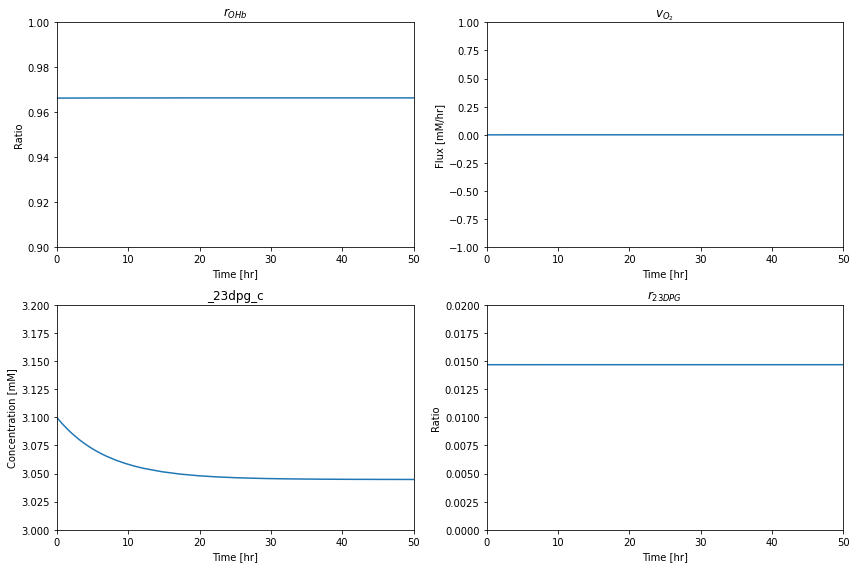

In [18]:
t0, tf = (0, 50)
sim_hb = Simulation(hemoglobin)
conc_sol, flux_sol = sim_hb.simulate(
    hemoglobin, time=(t0, tf))

equation_dict = {
    "$r_{OHb}$": [
        "(hb_1o2_c + 2*hb_2o2_c + 3*hb_3o2_c + 4*hb_4o2_c)/(4 * {0})".format(numerical_values[hb_total_sym]),
        ["hb_1o2_c", "hb_2o2_c", "hb_3o2_c", "hb_4o2_c"]],
    "$r_{23DPG}$": [
        "dhb_c/(_23dpg_c + dhb_c)",
        ["dhb_c", "_23dpg_c"]]}

for ratio_id, (equation, variables) in equation_dict.items():
    conc_sol.make_aggregate_solution(
        ratio_id, equation, variables)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
(ax1, ax2, ax3, ax4) = axes.flatten()

plot_time_profile(
    conc_sol, observable=list(equation_dict)[0], ax=ax1,
    xlabel="Time [hr]", ylabel="Ratio", 
    xlim=(t0, tf), ylim=(0.9, 1),
    title=(list(equation_dict)[0], L_FONT));

plot_time_profile(
    flux_sol, observable="SK_o2_c", ax=ax2,
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    xlim=(t0, tf), ylim=(-1, 1),
    title=("$v_{O_2}$", L_FONT));

plot_time_profile(
    conc_sol, observable="_23dpg_c", ax=ax3,
    xlabel="Time [hr]", ylabel="Concentration [mM]", 
    xlim=(t0, tf), ylim=(3.0, 3.2),
    title=("_23dpg_c", L_FONT));

plot_time_profile(
    conc_sol, observable=list(equation_dict)[1], ax=ax4,
    xlabel="Time [hr]", ylabel="Ratio", 
    xlim=(t0, tf), ylim=(0, .02),
    title=(list(equation_dict)[1], L_FONT));
fig.tight_layout()

We note that the slight decrease in the 23DPG concentration and update the condition accordingly. 

In [19]:
sim_hb.find_steady_state(
    hemoglobin, strategy="simulate", update_values=True);

The two ratios that characterize the state of the hemoglobin module are computed to be: 

In [20]:
for ratio_id in list(equation_dict):
    print("{0}: {1:.3f}".format(ratio_id, conc_sol[ratio_id][-1]))

$r_{OHb}$: 0.966
$r_{23DPG}$: 0.015


$$\begin{equation} r_{OHb} = 0.97,\ r_{23DPG} = 0.015 \tag{13.15} \end{equation}$$

Thus, in this steady state, the oxygen carrying capacity of hemoglobin is 97% utilized. Only 1.5% of the 23DPG is bound to hemoglobin. At this low 23DPG loading, the sequestration of hemoglobin into the deoxy form is highly sensitive to changes in the concentration of the 23DPG, making it an effective regulator. Both of these features meet expectations of physiological function, i.e., almost full use of oxygen carrying capacity while being highly sensitive to a key regulatory signal. 

### Dynamic responses  
The oxygenated state of hemoglobin will respond to the partial pressure of oxygen in the plasma. At sea level, the partial pressure of oxygen in blood will change from a high of about 100 mmHg leaving the lung and 40 mmHg in venus blood leaving tissues. In the dynamic simulations below, we will use the average oxygen partial pressure of 70 mmHg and an oscillation from 40 to 100 mmHg as a time-variant environ- ment during circulations. The average partial pressure can be dropped to simulate increased altitude.

The dynamic response of this system around the defined steady state can be performed. There are two cases of particular interest. First would be physiologically meaningful oscillations in the oxygen concentrations in the plasma, and second, changes to the average oxygen concentration in the plasma that would, for instance, correspond to significant altitude changes. The former is rapid while the latter is slow. 

#### Normal circulation  
The average circulation time of a RBC in the human body is about 1 minute. The partial pressure of oxygen in plasma should vary between 100 mmHg and 40 mmHg. To simulate the circulation cycle, we pick a sinusoidal oscillatory forcing function on the oxygen plasma and simulate the response. We center the oscillation on 70 mmHg as the midway point.  The reader can formulate different forcing functions that are more physiological, keeping in mind that the average capillary transit time is on the order of one second.  In studying a forcing function that represent such a rapid transit time, one has to be cognizant of that the numerical values of the hemoglobin loading and unloading processes are.

The simulated response of the state of the hemoglobin molecule to a sinusoidal forcing function is shown in Figure 13.3. The fractional oxygen loading, $r_{OHb}$, shows how hemoglobin is highly saturated at 100 mmHg and that it drops to a low level at 40 mmHg, Figure 13.3a. The exchange of oxygen in and out of the hemoglobin module shows how oxygen might be flowing in and out of the RBC during the simulated circulation cycle, Figure 13.3b. Integrating the $v_{O_2}$ curve shows that the oxygen loading and delivery is 2.8 mM/L/cycle. For a blood volume of 4.5 liters, this corresponds to 12.6 mmol/cycle or 0.76 mol/h for 60 cycles per hour. This number is in the range of oxygen consumption for an adult male. 

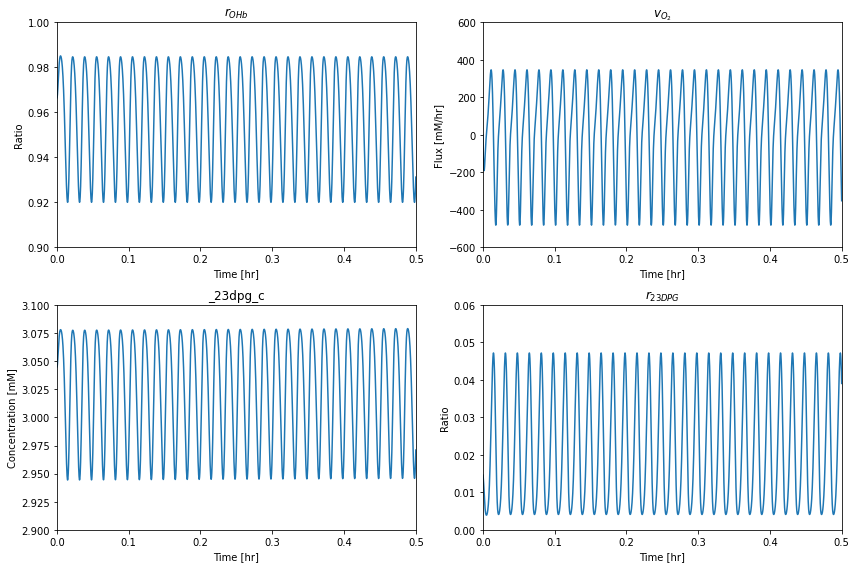

In [21]:
(t0, tf) = (0, 0.5)

conc_sol, flux_sol = sim_hb.simulate(
    hemoglobin, time=(t0, tf),
    perturbations={"o2_b": "(70 + 30*sin(120*pi*t))*2.8684*1e-4"},
    interpolate=True)

fig_13_3, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
(ax1, ax2, ax3, ax4) = axes.flatten()


for ratio_id, (equation, variables) in equation_dict.items():
    conc_sol.make_aggregate_solution(
        ratio_id, equation, variables)

plot_time_profile(
    conc_sol, observable=list(equation_dict)[0], ax=ax1,
    xlabel="Time [hr]", ylabel="Ratio", 
    xlim=(t0, tf), ylim=(0.9, 1),
    title=(list(equation_dict)[0], L_FONT));

plot_time_profile(
    flux_sol, observable="SK_o2_c", ax=ax2,
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    xlim=(t0, tf), ylim=(-600, 600),
    title=("$v_{O_2}$", L_FONT));

plot_time_profile(
    conc_sol, observable="_23dpg_c", ax=ax3,
    xlabel="Time [hr]", ylabel="Concentration [mM]", 
    xlim=(t0, tf), ylim=(2.9, 3.1),
    title=("_23dpg_c", L_FONT));

plot_time_profile(
    conc_sol, observable=list(equation_dict)[1], ax=ax4,
    xlabel="Time [hr]", ylabel="Ratio", 
    xlim=(t0, tf), ylim=(0, .06),
    title=(list(equation_dict)[1], L_FONT));
fig_13_3.tight_layout()

**Figure 13.3:** The binding states of hemoglobin during normal circulation. (a) $r_{OHb}$. (b) $v_{O_2}$. (c) 23DPG concentration. (d) 23DPG loading of hemoglobin.


The loading and unloading of oxygen on hemoglobin can be visualized by graphing the oxygen loading $r_{OHb}$ versus the plasma partial pressure of oxygen on the same plot as the saturation curve, Figure 13.4a. The displacement of 23DPG during circulation is shown in Figure 13.3c and $r_{23DPG}$ is graphed in Figure 13.3d. We see how the loading and unloading of oxygen on hemoglobin is a cycle between the saturation curves that correspond the the maximum and minimum concentration of 23DPG during the cycle. Note how narrow the range of operation is, but is sufficient to get high rates of oxygen delivery from the lung to the tissues. Finally, it is useful to look at the $r_{OHb}$ vs. $r_{23DPG}$ when they are plotted against each other, Figure 13.4b. 

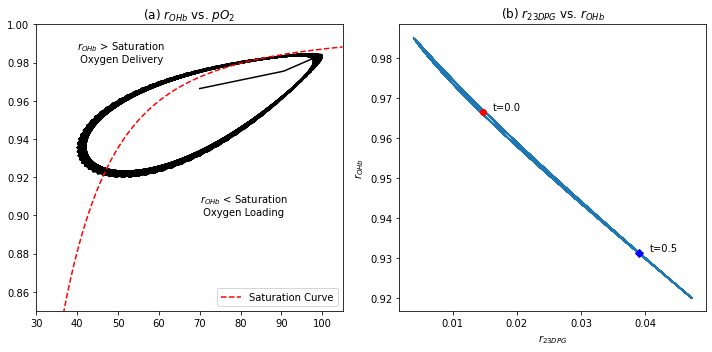

In [22]:
def saturation_curve(points):
    sol = np.zeros(points.shape)
    # Specify an equation for the oxygen occupancy and capacity of hemoglobin
    Hb_occupancy = sym.sympify(
        "+".join([
            "1*hb_1o2_c", "2*hb_2o2_c", "3*hb_3o2_c", "4*hb_4o2_c" ]), 
        locals=met_symbols)
    Hb_capacity = sym.sympify(
        "+".join([
            met for met in metabolite_ids if "hb" in met]), 
        locals=met_symbols)*4
    ratio = Hb_occupancy/Hb_capacity
    ratio = ratio.subs(heme_product_equations)
    ratio = ratio.subs({
        met: ic for met, ic in concentrations.items()
        if str(met) != "o2_c" and str(met) != "_23dpg_c"})
    
    for i, x in enumerate(points): # np.linspace(30, 105, 1000)
        sol[i] = float(ratio.subs({met_symbols["_23dpg_c"]: 0, 
                                   met_symbols["o2_c"]: x*2.8684*1e-4}))
             
    return sol

npoints = 250

fig_13_4, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
(ax1, ax2) = axes.flatten()

# Plot saturation curve
ax1.plot([(70 + 30*np.sin(120*np.pi*t))
          for t in np.linspace(t0, tf, npoints)], 
          conc_sol[list(equation_dict)[0]](np.linspace(t0, tf, npoints)),
         "k")

ax1.plot(np.linspace(30, 105, npoints),
         saturation_curve(np.linspace(30, 105, npoints)), 
         "r--", label="Saturation Curve")

# Annotate plot
ax1.annotate("$r_{OHb}$ < Saturation\n Oxygen Loading", xy=(70, .9));
ax1.annotate("$r_{OHb}$ > Saturation\n Oxygen Delivery", xy=(40, .98));
ax1.set_xlim(30, 105);
ax1.set_ylim(0.85, 1);
ax1.set_title("(a) $r_{OHb}$ vs. $pO_{2}$", fontdict=L_FONT);
ax1.legend(loc="lower right");

plot_phase_portrait(
    conc_sol, x=list(equation_dict)[1], y=list(equation_dict)[0], ax=ax2,
    xlabel=list(equation_dict)[1], ylabel=list(equation_dict)[0],
    title=("(b) {0} vs. {1}".format(
        list(equation_dict)[1], list(equation_dict)[0]),
           L_FONT),
    annotate_time_points="endpoints",
    annotate_time_points_labels=True);
fig_13_4.tight_layout()

**Figure 13.4:**  The dynamic version of the hemoglobin binding curve. (a) $r_{OHb}$ vs. $pO_2$ in mmHg cycle shown with the hemoglobin saturation curve. (b) The oscillation in the fraction of the 23DPG regulator bound to hemoglobin as a function of $r_{OHb}$.

#### Response to altitude change 
The second situation of interest is a change in the average partial pressure of oxygen. Here, we drop it to 38 mmHg, representing a move to 12000 ft elevation [4]. This change induces a long-term change in the DPG23 concentration (see Figure 13.5) that in turn induces a left shift in the oxygen–Hb binding curve; Figure 13.2.

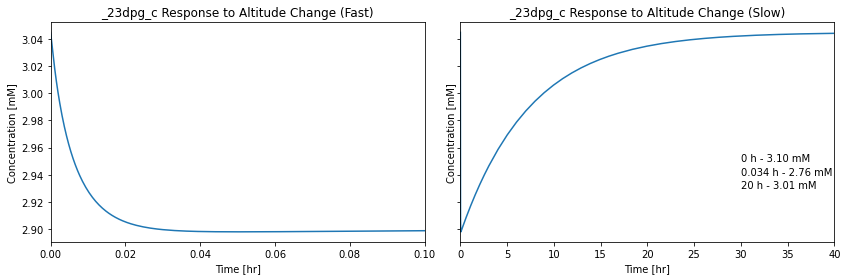

In [23]:
(t0, tf) = (0, 40)

conc_sol, flux_sol = sim_hb.simulate(
    hemoglobin, time=(t0, tf),
    perturbations={"o2_b": "o2_b/70 * 47"})

fig_13_5, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True)
(ax1, ax2) = axes.flatten()
plot_time_profile(
    conc_sol, observable="_23dpg_c", ax=ax1, 
    xlim=(t0, 0.1), xlabel="Time [hr]", ylabel="Concentration [mM]", 
    title=("_23dpg_c Response to Altitude Change (Fast)", L_FONT))

plot_time_profile(
    conc_sol, observable="_23dpg_c", ax=ax2, 
    xlim=(t0, tf), xlabel="Time [hr]", ylabel="Concentration [mM]", 
    title=("_23dpg_c Response to Altitude Change (Slow)", L_FONT))

ax2.annotate("0 h - 3.10 mM", xy=(30, 2.95));
ax2.annotate("0.034 h - 2.76 mM", xy=(30, 2.94));
ax2.annotate("20 h - 3.01 mM", xy=(30, 2.93));
fig_13_5.tight_layout()

**Figure 13.5:** Dynamic response of the 23DPG concentration when the average partial pressure of oxygen drops from 70 mmHg at sea level to to 38 mmHg at 12,000 feet.

## Integration with the Core Metabolic Network  
The unique red blood cell metabolite 23DPG is produced by a bypass on glycolysis. This bypass can be integrated with the combined core metabolic model of Chapter 12. This integration is seamless as 23DPG will leave from the 13DPG node and re-enter at the 3PG node. 

![Figure-13-6](../images/Ch13/Figure-13-6.png)

**Figure 13.6:** The core metabolic network in the human red blood cell comprised of glycolysis, the pentose phosphate pathway, AMP Salvage network, and hemoglobin.

First, we set up the core metabolic network as done in Chapter 12.

In [24]:
glycolysis = create_example_model("SB2_Glycolysis")
ppp = create_example_model("SB2_PentosePhosphatePathway")
ampsn = create_example_model("SB2_AMPSalvageNetwork")

core_hb = glycolysis.merge(ppp, inplace=False)
core_hb.merge(ampsn, inplace=True)
core_hb.remove_reactions([
    r for r in core_hb.boundary
    if r.id in [
        "SK_g6p_c", "DM_f6p_c", "DM_g3p_c", "DM_r5p_c",
        "DM_amp_c", "SK_amp_c"]])
core_hb.remove_boundary_conditions([
    "g6p_b", "f6p_b", "g3p_b", "r5p_b", "amp_b"])

# Note that reactants have negative coefficients and products have positive coefficients
core_hb.reactions.PRPPS.subtract_metabolites({
    core_hb.metabolites.atp_c: -1,
    core_hb.metabolites.adp_c: 2})
core_hb.reactions.PRPPS.add_metabolites({
    core_hb.metabolites.amp_c: 1})

Ignoring reaction 'SK_h_c' since it already exists.
Ignoring reaction 'SK_h2o_c' since it already exists.
Ignoring reaction 'ATPM' since it already exists.
Ignoring reaction 'SK_amp_c' since it already exists.
Ignoring reaction 'SK_h_c' since it already exists.
Ignoring reaction 'SK_h2o_c' since it already exists.


We then add the hemoglobin subnetwork to this:

In [25]:
hemoglobin = create_example_model("SB2_Hemoglobin")
core_hb.merge(hemoglobin, inplace=True)
core_hb.id = "RBC"

### Organization of the stoichiometric matrix
As in the previous chapter, we can perform a set of transformations to group the species and reactions into organized groups.  

In [26]:
# Define new order for metabolites
new_metabolite_order = [
    "glc__D_c", "g6p_c", "f6p_c", "fdp_c", "dhap_c","g3p_c", 
    "_13dpg_c", "_3pg_c", "_2pg_c", "pep_c", "pyr_c", "lac__L_c", 
    "_6pgl_c", "_6pgc_c", "ru5p__D_c",  "xu5p__D_c", "r5p_c", 
    "s7p_c", "e4p_c", "ade_c", "adn_c", "imp_c", "ins_c", "hxan_c", 
    "r1p_c", "prpp_c", "_23dpg_c","hb_c", "hb_1o2_c", "hb_2o2_c", 
    "hb_3o2_c", "hb_4o2_c", "dhb_c", "nad_c", "nadh_c", "amp_c", 
    "adp_c", "atp_c", "nadp_c", "nadph_c", "gthrd_c", "gthox_c", 
    "pi_c", "h_c", "h2o_c", "co2_c", "nh3_c", "o2_c"]
if len(core_hb.metabolites) == len(new_metabolite_order):
    core_hb.metabolites = DictList(core_hb.metabolites.get_by_any(new_metabolite_order))
# Define new order for reactions
new_reaction_order = [
    "HEX1", "PGI", "PFK", "FBA", "TPI", "GAPD", "PGK", "PGM", 
    "ENO", "PYK", "LDH_L", "G6PDH2r", "PGL", "GND", "RPE", 
    "RPI", "TKT1", "TKT2", "TALA", "ADNK1", "NTD7", "ADA","AMPDA", 
    "NTD11", "PUNP5", "PPM", "PRPPS", "ADPT", "ADK1", "DPGM", 
    "DPGase", "HBDPG", "HBO1", "HBO2", "HBO3", "HBO4", "ATPM", 
    "DM_nadh","GTHOr", "GSHR", "SK_glc__D_c", "SK_pyr_c", "SK_lac__L_c",
    "SK_ade_c", "SK_adn_c", "SK_ins_c", "SK_hxan_c","SK_pi_c", 
    "SK_h_c", "SK_h2o_c", "SK_co2_c", "SK_nh3_c", "SK_o2_c"]
if len(core_hb.reactions) == len(new_reaction_order):
    core_hb.reactions = DictList(core_hb.reactions.get_by_any(new_reaction_order))

The combined stoichiometric matrix is a straightforward integration of the stoichiometric matrices for the two subsystems being combined, see Table 13.8. Note that the matrix has a 2x2 block diagonal structure, as emphasized by the dashed lines. The lower off-diagonal block has no non-zero entries as none of the compounds in the hemoglobin subnetwork participate in any of the glycolytic reactions. The upper-right off-diagonal block has the enzymes that make and degrade 23DPG and represent the coupling between the glycolytic and hemoglobin subnetworks. The stoichiometric matrix of the core network with the hemoglobin module has dimensions of 48x53 and its rank is 44. The null is of dimension 9 (=53-44) and the left null space is of dimension 4 (=48-44). The matrix is elementally balanced. 

We have used colors in Table 13.8 to illustrate the organized structure of the matrix.

**Table 13.8:** The stoichiometric matrix for the merged core network model in Figure 13.6. The matrix is partitioned to show the glycolytic reactions (yellow) separate from the pentose phosphate pathway (light blue), the AMP salvage network (light green) and the Rapoport-Luebering (R.L.) shunt with the binding states of hemoglobin(light red). The cofactors (light orange) and inorganics (pink) are also grouped and shown. The connectivities, $\rho_i$ (red), for a compound, and the participation number, $\pi_j$ (cyan), for a reaction are shown. The second block in the table is the product $\textbf{ES}$ (blue) to evaluate elemental balancing status of the reactions. All exchange reactions have a participation number of unity and are thus not elementally balanced. The last block in the table has the 9 pathway vectors (purple) for the merged model.

In [27]:
# Define labels
metabolite_ids = [m.id for m in core_hb.metabolites]
reaction_ids = [r.id for r in core_hb.reactions]

pi_str = r"$\pi_{j}$"
rho_str = r"$\rho_{i}$"
chopsnq = ['C', 'H', 'O', 'P', 'N', 'S', 'q', '[HB]', '[NAD]', '[NADP]',]
time_inv_labels = ["$N_{\mathrm{tot}}$", "$NP_{\mathrm{tot}}$", "$G_{\mathrm{tot}}$", "$Hb_{\mathrm{tot}}$"]
path_labels = ["$p_1$", "$p_2$", "$p_3$", "$p_4$", 
               "$p_5$", "$p_6$", "$p_7$", "$p_8$", "$p_9$"]

# Make table content from the stoichiometric matrix, elemental balancing of pathways
# participation number, and MinSpan pathways 
S_matrix = core_hb.update_S(array_type="dense", dtype=np.int64, update_model=False)
ES_matrix = core_hb.get_elemental_charge_balancing(dtype=np.int64)
pi = np.count_nonzero(S_matrix, axis=0)
rho = np.count_nonzero(S_matrix, axis=1)
minspan_paths = np.array([
    [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0,-1, 1, 0, 0, 0, 0, 0,-2, 0, 0, 0, 0],
    [1,-2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 6, 1, 0, 1, 0, 0, 0, 0, 0,13,-3, 3, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 1, 0, 0, 0, 4, 0, 1, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 0, 1, 0, 0, 4,-1, 1, 1, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 0, 1, 0, 0, 4,-1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-2, 0, 0, 0, 0, 0, 0,-1, 0, 0, 1, 0, 0,-1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0]
])
table_13_8 = np.vstack((S_matrix, pi, ES_matrix, minspan_paths))

# Determine number of blank entries needed to be added to pad the table,
# Add connectivity number and time invariants to table content
blanks = [""]*(len(table_13_8) - len(metabolite_ids))
rho = np.concatenate((rho, blanks))

lns = np.zeros((4, 48), dtype=np.int64)
lns[0][33:35] = 1
lns[1][38:40] = 1
lns[2][40] = 1
lns[2][41] = 2
lns[3][27:33] = 1

time_inv = np.array([np.concatenate([row, blanks]) for row in lns])
table_13_8 = np.vstack([table_13_8.T, rho, time_inv]).T

colors = {"glycolysis": "#ffffe6",    # Yellow
          "ppp": "#e6faff",           # Light blue
          "ampsn": "#d9fad2",         # Light green
          "hemoglobin": "#ffcccc",    # Light red
          "cofactor": "#ffe6cc",      # Orange
          "inorganic": "#fadffa",     # Pink
          "chopsnq": "#99e6ff",       # Blue
          "pathways": "#b399ff",      # Purple
          "pi": "#99ffff",            # Cyan
          "rho": "#ff9999",           # Red
          "time_invs": "#ccff99",     # Green
          "blank": "#f2f2f2"}         # Grey
bg_color_str = "background-color: "
cofactor_mets = ["nad_c", "nadh_c",  "amp_c", "adp_c", "atp_c", 
                 "nadp_c", "nadph_c", "gthrd_c", "gthox_c"]
exch_misc_rxns= ["SK_glc__D_c", "SK_pyr_c", "SK_lac__L_c", "SK_ade_c", "SK_adn_c",
                 "SK_ins_c", "SK_hxan_c", "ATPM", "DM_nadh", "GTHOr", "GSHR"]
inorganic_mets = ["pi_c", "h_c", "h2o_c", "co2_c", "nh3_c", "o2_c"]
inorganic_exch = ["SK_pi_c", "SK_h_c", "SK_h2o_c", "SK_co2_c", "SK_nh3_c", "SK_o2_c"]

def highlight_table(df, model):
    df = df.copy()     
    condition = lambda mmodel, row, col, c1, c2:  (
        (col not in exch_misc_rxns + inorganic_exch) and (row not in cofactor_mets + inorganic_mets) and (
            (row in mmodel.metabolites and c1) or (col in mmodel.reactions or c2)))
    inorganic_condition = lambda row, col: (col in inorganic_exch or row in inorganic_mets)
    for i, row in enumerate(df.index):
        for j, col in enumerate(df.columns):
            if df.loc[row, col] == "":
                main_key = "blank"
            elif row in pi_str:
                main_key = "pi"
            elif row in chopsnq:
                main_key = "chopsnq"
            elif row in path_labels:
                main_key = "pathways"
            elif col in rho_str:
                main_key = "rho"
            elif col in time_inv_labels:
                main_key = "time_invs"
            elif condition(hemoglobin, row, col, row not in ["_13dpg_c", "_3pg_c"], False):
                main_key = "hemoglobin"
            elif condition(ampsn, row, col, row not in ["r5p_c"], col in ["ADK1"]):
                main_key = "ampsn"
            elif condition(ppp, row, col, row not in ["g6p_c", "f6p_c", "g3p_c"], False):
                main_key = "ppp"
            elif condition(glycolysis, row, col, True, False):
                main_key = "glycolysis"
            elif ((col in exch_misc_rxns or row in cofactor_mets) and not inorganic_condition(row, col)):
                main_key = "cofactor"
            elif inorganic_condition(row, col):
                main_key = "inorganic"
            else:
                continue
            df.loc[row, col] = bg_color_str + colors[main_key]  
    return df

# Create index and column labels
index_labels = np.concatenate((metabolite_ids, [pi_str], chopsnq, path_labels))
column_labels = np.concatenate((reaction_ids, [rho_str], time_inv_labels))
# Create DataFrame
table_13_8 = pd.DataFrame(
    table_13_8, index=index_labels, columns=column_labels)
# Apply colors
table_13_8 = table_13_8.style.apply(
    highlight_table,  model=core_hb, axis=None)
table_13_8

,HEX1,PGI,PFK,FBA,TPI,GAPD,PGK,PGM,ENO,PYK,LDH_L,G6PDH2r,PGL,GND,RPE,RPI,TKT1,TKT2,TALA,ADNK1,NTD7,ADA,AMPDA,NTD11,PUNP5,PPM,PRPPS,ADPT,ADK1,DPGM,DPGase,HBDPG,HBO1,HBO2,HBO3,HBO4,ATPM,DM_nadh,GTHOr,GSHR,SK_glc__D_c,SK_pyr_c,SK_lac__L_c,SK_ade_c,SK_adn_c,SK_ins_c,SK_hxan_c,SK_pi_c,SK_h_c,SK_h2o_c,SK_co2_c,SK_nh3_c,SK_o2_c,$\rho_{i}$,$N_{\mathrm{tot}}$,$NP_{\mathrm{tot}}$,$G_{\mathrm{tot}}$,$Hb_{\mathrm{tot}}$
glc__D_c,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0
g6p_c,1,-1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0
f6p_c,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0
fdp_c,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0
dhap_c,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0
g3p_c,0,0,0,1,1,-1,0,0,0,0,0,0,0,0,0,0,1,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0
_13dpg_c,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0
_3pg_c,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0
_2pg_c,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0
pep_c,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0


### The pathway structure:
The null space of the integrated stoichiometric matrix has a dimension of 9. Eight of the pathways are the same as the previous chapter (Table 12.10).  The new pathway $\textbf{p}_9$, represents flow through glycolysis and through the Rapoport-Luebering shunt, bypassing the ATP generating PGK. This pathway thus produces no net ATP, but an inorganic phosphate with the degradation of 23DPG. Thus, the 23DPG ligand that regulates the oxygen affinity of hemoglobin costs the red blood cell the opportunity to make one ATP. 

## Defining the Steady State
The steady state concentrations for the glycolytic intermediates can stay the same as before. The new steady state concentration that needs to be added is that of 23DPG. All glycolytic fluxes stay the same except for PGK. The PGK flux needs to be reduced by the amount that goes through the Rapoport-Luebering shunt: 0.441 mM/hr. This creates minor changes in the estimated PERCs from this steady state data.

In [28]:
# Set independent fluxes to determine steady state flux vector
independent_fluxes = {
    core_hb.reactions.SK_glc__D_c: 1.12, 
    core_hb.reactions.DM_nadh: 0.2*1.12, 
    core_hb.reactions.GSHR : 0.42, 
    core_hb.reactions.SK_ade_c: -0.014, 
    core_hb.reactions.ADA: 0.01,
    core_hb.reactions.SK_adn_c: -0.01, 
    core_hb.reactions.ADNK1: 0.12, 
    core_hb.reactions.SK_hxan_c: 0.097,
    core_hb.reactions.DPGM: 0.441}

ssfluxes = core_hb.compute_steady_state_fluxes(
    minspan_paths, 
    independent_fluxes,
    update_reactions=True)
table_13_8 = pd.DataFrame(list(ssfluxes.values()), index=reaction_ids, 
                          columns=[r"$\textbf{v}_{\mathrm{stst}}$"]).T

**Table 13.8:**	The steady state fluxes as a summation of the MinSpan pathway vectors.

In [29]:
table_13_8

,HEX1,PGI,PFK,FBA,TPI,GAPD,PGK,PGM,ENO,PYK,LDH_L,G6PDH2r,PGL,GND,RPE,RPI,TKT1,TKT2,TALA,ADNK1,NTD7,ADA,AMPDA,NTD11,PUNP5,PPM,PRPPS,ADPT,ADK1,DPGM,DPGase,HBDPG,HBO1,HBO2,HBO3,HBO4,ATPM,DM_nadh,GTHOr,GSHR,SK_glc__D_c,SK_pyr_c,SK_lac__L_c,SK_ade_c,SK_adn_c,SK_ins_c,SK_hxan_c,SK_pi_c,SK_h_c,SK_h2o_c,SK_co2_c,SK_nh3_c,SK_o2_c
$\textbf{v}_{\mathrm{stst}}$,1.120,0.910,1.105,1.105,1.105,2.308,1.867,2.308,2.308,2.308,2.084,0.210,0.210,0.210,0.195,0.015,0.098,0.098,0.098,0.120,0.120,0.010,0.014,0.014,0.097,0.097,0.014,0.014,-0.014,0.441,0.441,0.000,0.000,0.000,0.000,0.000,2.243,0.224,0.420,0.420,1.120,0.224,2.084,-0.014,-0.010,-0.073,0.097,0.000,3.596,-0.317,0.210,0.024,0.000


These vectors can be visualized as a bar chart:

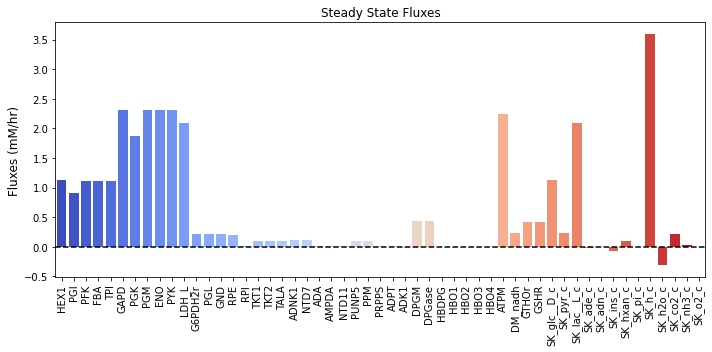

In [30]:
fig_13_7, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
# Define indicies for bar chart
indicies = np.arange(len(reaction_ids))+0.5
# Define colors to use
c = plt.cm.coolwarm(np.linspace(0, 1, len(reaction_ids)))
# Plot bar chart
ax.bar(indicies, list(ssfluxes.values()), width=0.8, color=c);
ax.set_xlim([0, len(reaction_ids)]);
# Set labels and adjust ticks
ax.set_xticks(indicies);
ax.set_xticklabels(reaction_ids, rotation="vertical");
ax.set_ylabel("Fluxes (mM/hr)", L_FONT);
ax.set_title("Steady State Fluxes", L_FONT);
ax.plot([0, len(reaction_ids)], [0, 0], "k--");
fig_13_7.tight_layout()

**Figure 13.7:** Bar chart of the steady-state fluxes.

### Computing the rate constants  
The kinetic constants can be computed from the steady state values of the concentrations using elementary mass action kinetics. The computation is based on Eq. (10.4) The results from this computation is summarized in Table 13.9. This table has all the reaction properties that we need to complete the MASS model.

Note that we set some parameters manually for hemoglobin binding and the oxygen exchange to better reflect the binding of oxygen to hemoglobin.

In [31]:
percs = core_hb.calculate_PERCs(
    fluxes={
        r: flux for r, flux in core_hb.steady_state_fluxes.items()
        if r.id not in [
            "ADK1", "SK_o2_c", "HBDPG", "HBO1", "HBO2", "HBO3", "HBO4"]}, # Skip ADK1 and HB reactions
    update_reactions=True)
core_hb.reactions.SK_o2_c.kf = 509726
core_hb.reactions.HBDPG.kf =519613
core_hb.reactions.HBO1.kf = 506935
core_hb.reactions.HBO2.kf = 511077
core_hb.reactions.HBO3.kf = 509243
core_hb.reactions.HBO4.kf = 501595

**Table 13.9:** Combined glycolysis, pentose phosphate pathway, AMP salvage network, and hemoglobin model enzymes and transport rates.

In [32]:
# Get concentration values for substitution into sympy expressions
value_dict = {sym.Symbol(str(met)): ic 
              for met, ic in core_hb.initial_conditions.items()}
value_dict.update({sym.Symbol(str(met)): bc 
                   for met, bc in core_hb.boundary_conditions.items()})
table_13_9 = []
# Get symbols and values for table and substitution
for p_key in ["Keq", "kf"]:
    symbol_list, value_list = [], []
    for p_str, value in core_hb.parameters[p_key].items():
        symbol_list.append(r"$%s_{\text{%s}}$" % (p_key[0], p_str.split("_", 1)[-1]))
        value_list.append("{0:.3f}".format(value) if value != INF else r"$\infty$")
        value_dict.update({sym.Symbol(p_str): value})
    table_13_9.extend([symbol_list, value_list])

table_13_9.append(["{0:.6f}".format(float(ratio.subs(value_dict)))
                   for ratio in strip_time(core_hb.get_mass_action_ratios()).values()])
table_13_9.append(["{0:.6f}".format(float(ratio.subs(value_dict)))
                   for ratio in strip_time(core_hb.get_disequilibrium_ratios()).values()])
table_13_9 = pd.DataFrame(np.array(table_13_9).T, index=reaction_ids,
                          columns=[r"$K_{eq}$ Symbol", r"$K_{eq}$ Value", "PERC Symbol", 
                                   "PERC Value", r"$\Gamma$", r"$\Gamma/K_{eq}$"])
table_13_9

,$K_{eq}$ Symbol,$K_{eq}$ Value,PERC Symbol,PERC Value,$\Gamma$,$\Gamma/K_{eq}$
HEX1,$K_{\text{HEX1}}$,850.000,$k_{\text{HEX1}}$,0.700,0.008809,0.000010
PGI,$K_{\text{PGI}}$,0.410,$k_{\text{PGI}}$,2961.111,0.407407,0.993677
PFK,$K_{\text{PFK}}$,310.000,$k_{\text{PFK}}$,34.906,0.133649,0.000431
FBA,$K_{\text{FBA}}$,0.082,$k_{\text{FBA}}$,2797.449,0.079781,0.972937
TPI,$K_{\text{TPI}}$,0.057,$k_{\text{TPI}}$,33.906,0.045500,0.796249
GAPD,$K_{\text{GAPD}}$,0.018,$k_{\text{GAPD}}$,3479.760,0.006823,0.381183
PGK,$K_{\text{PGK}}$,1800.000,$k_{\text{PGK}}$,1061655.085,1755.073081,0.975041
PGM,$K_{\text{PGM}}$,0.147,$k_{\text{PGM}}$,5017.110,0.146184,0.994048
ENO,$K_{\text{ENO}}$,1.695,$k_{\text{ENO}}$,1817.545,1.504425,0.887608
PYK,$K_{\text{PYK}}$,363000.000,$k_{\text{PYK}}$,468.247,19.570304,0.000054


## Simulating the Dynamic Mass Balance
### Validating the steady state
As usual, we must first ensure that the system is originally at steady state:

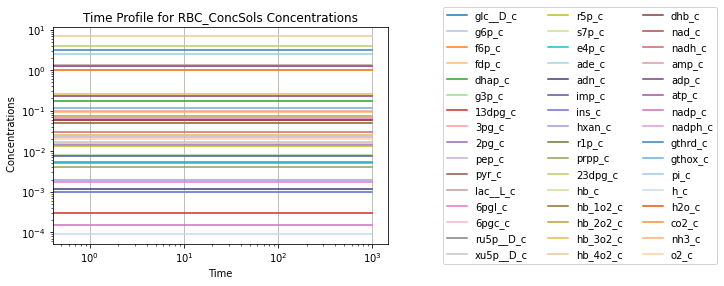

In [33]:
t0, tf = (0, 1e3)
sim_core = Simulation(core_hb)
sim_core.find_steady_state(
    core_hb, strategy="simulate",
    update_values=True)
conc_sol_ss, flux_sol_ss = sim_core.simulate(
    core_hb, time=(t0, tf))
# Quickly render and display time profiles 
conc_sol_ss.view_time_profile()

**Figure 13.8:** The merged model after determining the steady state conditions.

We can compare the differences in the initial state of each model before merging and after. 

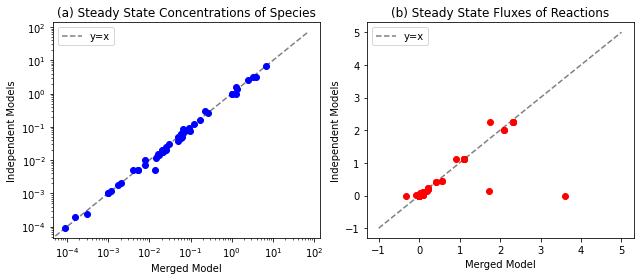

In [34]:
fig_13_9, axes = plt.subplots(1, 2, figsize=(9, 4))
(ax1, ax2) = axes.flatten()

# Compare initial conditions
initial_conditions = {
    m.id: ic for m, ic in glycolysis.initial_conditions.items()
    if m.id in core_hb.metabolites}
initial_conditions.update({
    m.id: ic for m, ic in ppp.initial_conditions.items()
    if m.id in core_hb.metabolites})
initial_conditions.update({
    m.id: ic for m, ic in ampsn.initial_conditions.items()
    if m.id in core_hb.metabolites})
initial_conditions.update({
    m.id: ic for m, ic in hemoglobin.initial_conditions.items()
    if m.id in core_hb.metabolites})

plot_comparison(
    core_hb, pd.Series(initial_conditions), compare="concentrations",
    ax=ax1, plot_function="loglog",
    xlabel="Merged Model", ylabel="Independent Models",
    title=("(a) Steady State Concentrations of Species", L_FONT),
    color="blue", xy_line=True, xy_legend="best");

# Compare fluxes
fluxes = {
    r.id: flux for r, flux in glycolysis.steady_state_fluxes.items()
    if r.id in core_hb.reactions}
fluxes.update({
    r.id: flux for r, flux in ppp.steady_state_fluxes.items()
    if r.id in core_hb.reactions})
fluxes.update({
    r.id: flux for r, flux in ampsn.steady_state_fluxes.items()
    if r.id in core_hb.reactions})
fluxes.update({
    r.id: flux for r, flux in hemoglobin.steady_state_fluxes.items()
    if r.id in core_hb.reactions})

plot_comparison(
    core_hb, pd.Series(fluxes), compare="fluxes", 
    ax=ax2, plot_function="plot",
    xlabel="Merged Model", ylabel="Independent Models",
    title=("(b) Steady State Fluxes of Reactions", L_FONT),
    color="red", xy_line=True, xy_legend="best");
fig_13_9.tight_layout()

**Figure 13.9:** Comparisons between the initial conditions of the merged model and the initial conditions of the independent glycolysis, pentose phosphate pathway, AMP salvage network and hemoglobin models for (a) the species and (b) the fluxes.

### Response to an increased $k_{ATPM}$
Once we have ensured that the system is originally at steady state, we perform the same simulation as in the last chapter by increasing the rate of ATP utilization. 

In [35]:
conc_sol, flux_sol = sim_core.simulate(
    core_hb, time=(t0, tf),
    perturbations={"kf_ATPM": "kf_ATPM * 1.5"},
    interpolate=True)

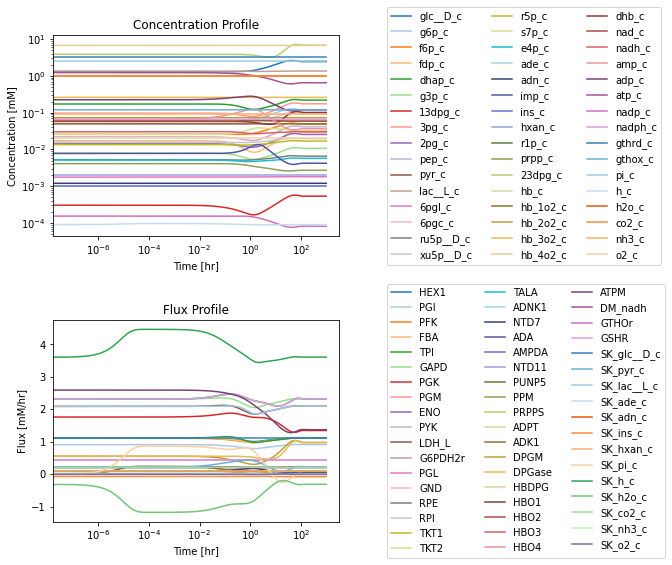

In [36]:
fig_13_10, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8));
(ax1, ax2) = axes.flatten()

plot_time_profile(
    conc_sol, ax=ax1, legend="right outside", 
    plot_function="loglog", 
    xlabel="Time [hr]", ylabel="Concentration [mM]", 
    title=("Concentration Profile", L_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside", 
    plot_function="semilogx", 
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("Flux Profile", L_FONT));
fig_13_10.tight_layout()

**Figure 13.10:** Simulating the combined system from the steady state with 50% increase in the rate of ATP utilization at $t = 0$.

 #### The proton node
The proton node now has a connectivity of 16 with 12 production reactions and 4 utilization reactions. The additional proton production reaction is due to the addition of DPGM to the model. 

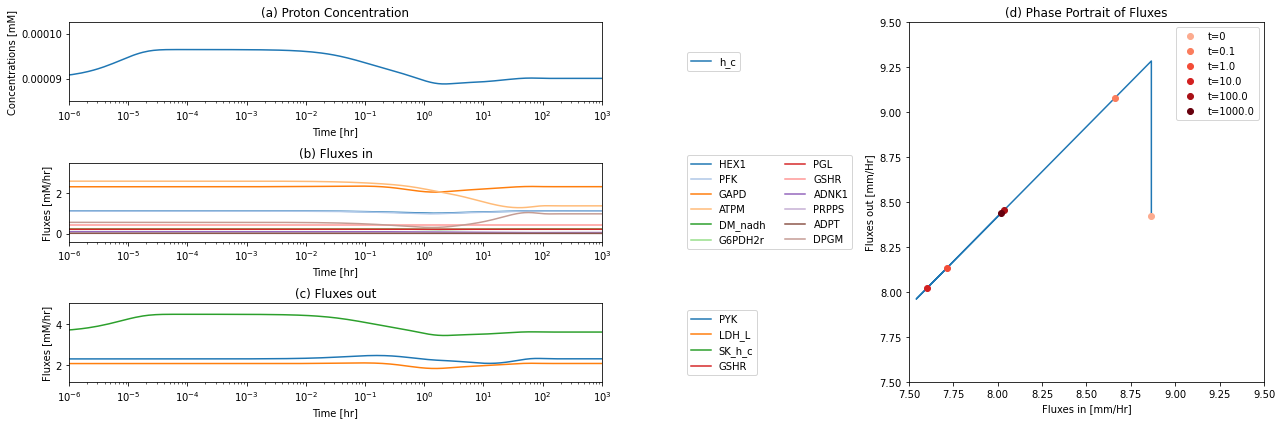

In [37]:
fig_13_11 = plt.figure(figsize=(18, 6))
gs = fig_13_11.add_gridspec(nrows=3, ncols=2, width_ratios=[1.5, 1])

ax1 = fig_13_11.add_subplot(gs[0, 0])
ax2 = fig_13_11.add_subplot(gs[1, 0])
ax3 = fig_13_11.add_subplot(gs[2, 0])
ax4 = fig_13_11.add_subplot(gs[:, 1])

plot_time_profile(
    conc_sol, observable="h_c", ax=ax1, 
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf), ylim=(8.5e-5, 1e-4*1.025),
    xlabel="Time [hr]", ylabel="Concentrations [mM]",
    title=("(a) Proton Concentration", L_FONT));

fluxes_in = ["HEX1", "PFK", "GAPD", "ATPM", "DM_nadh", "G6PDH2r",
             "PGL", "GSHR", "ADNK1", "PRPPS", "ADPT", "DPGM"]
plot_time_profile(
    flux_sol, observable=fluxes_in, ax=ax2,
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf),  ylim=(-0.4, 3.5),
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(b) Fluxes in", L_FONT));

fluxes_out = ["PYK", "LDH_L", "SK_h_c", "GSHR"]
plot_time_profile(
    flux_sol, observable=fluxes_out, ax=ax3, 
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf),  ylim=(1.2, 5), 
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(c) Fluxes out", L_FONT));

for flux_id, variables in zip(["Net_Flux_In", "Net_Flux_Out"],
                              [fluxes_in, fluxes_out]):
    flux_sol.make_aggregate_solution(
        flux_id, equation=" + ".join(variables), variables=variables)
    
time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

plot_phase_portrait(
    flux_sol, x="Net_Flux_In", y="Net_Flux_Out", ax=ax4,
    xlim=(7.5, 9.5), ylim=(7.5, 9.5),
    xlabel="Fluxes in [mm/Hr]", ylabel="Fluxes out [mm/Hr]",
    title=("(d) Phase Portrait of Fluxes", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="best");
fig_13_11.tight_layout()

**Figure 13.11:**	The time profiles of the (a) proton concentration, (b) the fluxes that make protons, (c) the fluxes that use protons and (d) the phase portrait of the net flux in and net flux out (darker red colors indicate slower time scales).

### Dynamic simulation: normal circulation  
We can repeat the response to the oscillatory plasma concentration of oxygen that we performed for the hemoglobin subsystem alone (Figure 13.3). The response of the integrated system demonstrates dynamic decoupling between the loading and offloading of oxygen on hemoglobin and glycolytic activity. 

The simulation demonstrates dynamic decoupling at the rapid time scales, namely that the loading and off-loading of oxygen on the minute time scale does not have significant ripple effects into glycolytic functions. The oxygen delivery and hemoglobin are unaltered as compared before (Figure 13.3a,b). The input into the Rapoport-Luebering shunt is effectively a constant while the output is slightly oscillatory Figure 13.12a, leading to small drift downwards in the first 0.1 hours and additional minor downstream effects on lower glycolysis, Figure 13.12b. Notice that the PYK flux is barely perturbed. 

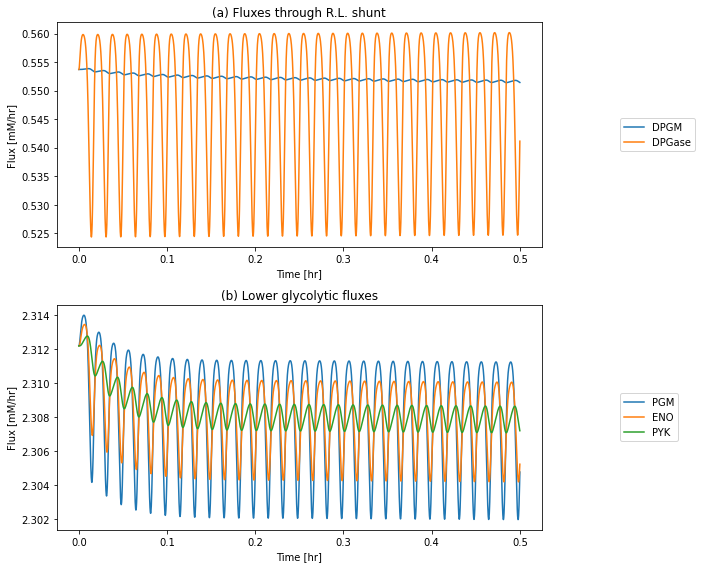

In [38]:
(t0, tf) = (0, 0.5)

conc_sol, flux_sol = sim_core.simulate(
    core_hb, time=(t0, tf),
    perturbations={"o2_b": "(70 + 30*sin(120*pi*t))*2.8684*1e-4"},
    interpolate=True)

fig_13_12, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
(ax1, ax2) = axes.flatten()

plot_time_profile(
    flux_sol, observable=["DPGM", "DPGase"], ax=ax1, 
    legend="right outside", xlabel="Time [hr]", ylabel="Flux [mM/hr]",
    title=("(a) Fluxes through R.L. shunt", L_FONT));

plot_time_profile(
    flux_sol, observable=["PGM", "ENO", "PYK"], ax=ax2, 
    legend="right outside", xlabel="Time [hr]", ylabel="Flux [mM/hr]",
    title=("(b) Lower glycolytic fluxes", L_FONT));
fig_13_12.tight_layout()

**Figure 13.12:** The binding states of hemoglobin during normal circulation as computed from the integrated core network and Rapoport-Luebering shunt model. (a): The fluxes through the Rapoport-Luebering shunt. (b): The lower glycolytic fluxes.

### Pools and ratios
The pools and ratios will be the same as for the two individual subsystems, with the exception of the role of 23DPG. In the total phosphate pool, it will count as a 2 since its two phosphate bonds. However, it has a high-energy bond value of 1 in the glycolytic energy pool $(GP^+)$ as it can only generate one ATP through degradation through pyruvate kinase. In the glycolytic redox pool it has a value of 0 as it cannot generate NADH. 

## Summary  

* The ligand binding to macromolecules can be described by chemical equations. Stoichiometric matrices that describe the binding states of macromolecules can be formulated. Such matrices can be integrated with stoichiometric matrices describing metabolic networks, thus forming integrated models of small molecules and protein. 

* Since hemoglobin is confined to the system, the rapid binding of the ligands lead to equilibrium states. These are not quasi-equilibria since the serial binding is a 'dead end,' meaning there is no output on the other end of the series of binding steps. Thus, the ligand bound states of the macromolecule are equilibrium variables that match the steady state values of the ligands. The ligands are in pathways that leave and enter the system and are thus in a steady state. 

* The oxygen loading of hemoglobin has fast and slow physiologically meaningful time scales: the one minute circulation time of the red blood cell, during which the oxygen molecules load and unload from hemoglobin, and the slow changes in 23DPG levels, resulting from changes in $pO_2$. The former does not show dynamic coupling with glycolysis and the pentose pathway, while the latter does. 

* The integration issues here are simple. The role of 23DPG in the pools and ratios needs to be defined. The flux split into the Rapoport-Luebering shunt leads to a different definition of PERCs for PGK, as the flux changes, but the steady state concentrations are assumed to be the same with and without the shunt. This easy integration is a reflection of the MASS procedure and its flexibility. 

$\tiny{\text{© B. Ø. Palsson 2011;}\ \text{This publication is in copyright.}\\ \text{Subject to statutory exception and to the provisions of relevant collective licensing agreements,}\\ \text{no reproduction of any part may take place without the written permission of Cambridge University Press.}}$